In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [49]:
#df = pd.read_csv("../data/consumer/braila_test.csv")

df = pd.read_csv("../data/consumer/conductivity_data.csv")

display(df)


#(x_train,y_train), _ = mnist.load_data ()
#x_train = x_train.astype('float32')/255.0
#x_train = x_train.reshape((len(x_train),np.prod(x_train.shape [1:])))

,Timestamp,Value
0,2021-02-24 00:00:00,9212.88900
1,2021-02-24 00:00:15,9210.90605
2,2021-02-24 00:00:30,9208.92310
3,2021-02-24 00:00:45,9206.94015
4,2021-02-24 00:01:00,9204.95720
...,...,...
207355,2021-03-31 23:58:45,5931.60400
207356,2021-03-31 23:59:00,5931.60400
207357,2021-03-31 23:59:15,5931.60400
207358,2021-03-31 23:59:30,5931.60400


10368
(9868, 500)
9868


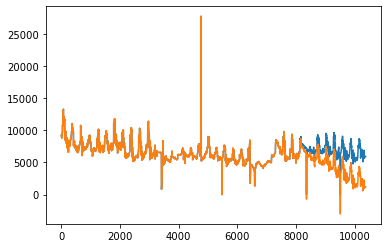

In [59]:
vals = df['Value'].values[::20].copy()
plt.plot(vals)
print(len(vals))

for i in range(8000, len(vals)):
    vals[i] -= (i-8000)*2

plt.plot(vals)
N = 500
FVs = []
for i in range(N, len(vals)):
    FV = vals[i-N:i]
    FVs.append(np.array(FV))
FVs = np.array(FVs)
print(FVs.shape)

x_train = (FVs-7000)/2000
print(len(x_train))

In [60]:
original_dim = np.prod(x_train.shape [1:]) # dimenzija vhodnih podatkov
print(original_dim)
hidden_dim = 500 # skriti sloj z 64 node -i
latent_dim = 30 # 2D latentni prostor
inputs = keras.Input(shape =(original_dim ,))
h1 = keras.layers.Dense(hidden_dim, activation ='linear')(inputs)
h2 = keras.layers.Dense(hidden_dim, activation ='tanh')(h1)
h3 = keras.layers.Dense(hidden_dim, activation ='tanh')(h2)

h4 = keras.layers.Dense(latent_dim, activation ='tanh')(h3)

z_mean = keras.layers.Dense(latent_dim)(h3)
z_log_var = keras.layers.Dense(latent_dim)(h3)

500


In [61]:
def sampling ( args ):
    z_mean , z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean =0.0 , stddev =1.0)
    return (z_mean + K.exp(0.5*z_log_var)*epsilon)

In [62]:
z = keras.layers.Lambda(sampling)([z_mean , z_log_var ])

#encoder = keras.Model(inputs, [z_mean , z_log_var , z], name ='encoder')

encoder = keras.Model(inputs, outputs = [h4, h4], name = 'encoder')

#latent_inputs = keras.Input(shape =(latent_dim,), name ='z_sampling')
latent_inputs = keras.Input(shape =latent_dim, name ='z_sampling')

x1 = keras.layers.Dense(hidden_dim , activation ='tanh')(latent_inputs)
x2 = keras.layers.Dense(hidden_dim , activation ='relu')(x1)
x3 = keras.layers.Dense(hidden_dim , activation ='relu')(x2)


outputs = keras.layers.Dense(original_dim , activation ='linear')(x3)
decoder = keras.Model(latent_inputs, outputs, name ='decoder')

outputs = decoder(encoder(inputs)[0])
vae = keras.Model(inputs, outputs, name ='vae')

#rec_loss = keras.losses.mean_squared_error(inputs, outputs)
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)
mse = tf.keras.losses.MeanSquaredError()

rec_loss = mse(inputs, outputs)

rec_loss *= 1000*original_dim
kl_loss = -0.0*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var) , axis =-1)
vae_loss = K.mean(rec_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer =tf.keras.optimizers.Adam(lr = 0.001, beta_1 = 0.95))

In [63]:
batch_size = 100
vae.fit(x_train[:5000],x_train[:5000], epochs =30, batch_size = batch_size, validation_data = None, verbose = 1)

Epoch 1/30
50/50 [==============================] - 2s 16ms/step - loss: 144574.1487
Epoch 2/30
50/50 [==============================] - 1s 16ms/step - loss: 56186.7907
Epoch 3/30
50/50 [==============================] - 1s 15ms/step - loss: 45190.5273
Epoch 4/30
50/50 [==============================] - 1s 15ms/step - loss: 38860.3558
Epoch 5/30
50/50 [==============================] - 1s 15ms/step - loss: 35164.3811
Epoch 6/30
50/50 [==============================] - 1s 15ms/step - loss: 33287.9192
Epoch 7/30
50/50 [==============================] - 1s 15ms/step - loss: 31796.4988
Epoch 8/30
50/50 [==============================] - 1s 15ms/step - loss: 29402.8746
Epoch 9/30
50/50 [==============================] - 1s 14ms/step - loss: 27359.2994
Epoch 10/30
50/50 [==============================] - 1s 13ms/step - loss: 27024.3185
Epoch 11/30
50/50 [==============================] - 1s 13ms/step - loss: 25480.9717
Epoch 12/30
50/50 [==============================] - 1s 13ms/step - loss:

[[ 0.09065856  0.24921854  0.12972412]
 [ 0.06153977  0.233135    0.12650783]
 [ 0.18182269  0.35493523  0.08594456]
 ...
 [ 0.1942619   0.40947983 -0.1341277 ]
 [ 0.0682623   0.2509975  -0.1079167 ]
 [ 0.03382505  0.1296018  -0.06878359]]


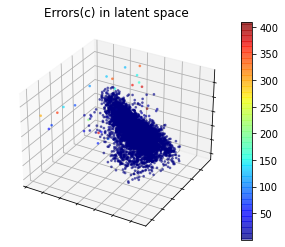

In [206]:
from mpl_toolkits import mplot3d
x_encoded = encoder.predict(x_train)[0]
print(x_encoded)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter3D(x_encoded[:,0], x_encoded[:,1], x_encoded[:,2],c = errors, cmap='jet', alpha = 0.5, s = 3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.set_title("Errors(c) in latent space")
fig.colorbar(p)
plt.savefig("GAN_Braila_LatentSpace")

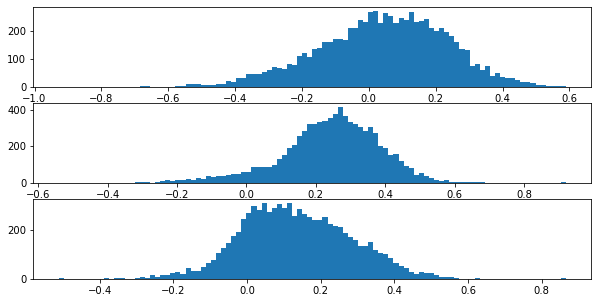

In [208]:
fig, axarr = plt.subplots(3, 1, figsize = (10, 5))
axarr[0].hist(x_encoded[:,0], bins = 100)
axarr[1].hist(x_encoded[:,1], bins = 100)
axarr[2].hist(x_encoded[:,2], bins = 100)
plt.show()

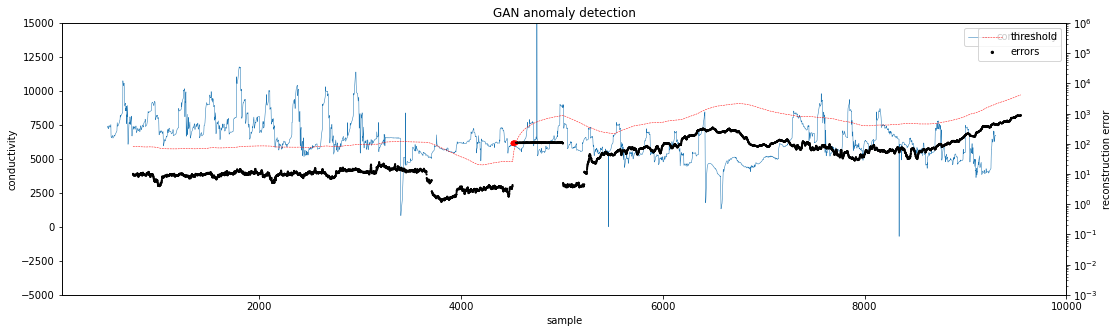

In [65]:
x_pred = vae.predict(x_train)
fr = 500
to = 9300
#plt.plot(x_pred[n], c = 'r')
#plt.plot(x_train[n], c = 'k')

def mse(vec1, vec2):
    mse = np.sum((np.add(np.array(vec1), -np.array(vec2))**2))
    return(mse)

latent = encoder.predict(x_train)[0]
errors = []
for i in range(len(x_pred)):
    errors.append(mse(x_pred[i], x_train[i]))

fig, ax1 = plt.subplots(figsize = (18, 5))
ax1.plot(range(fr, to), FVs[:,9][fr:to], lw = 0.5, label = 'conductivity')
plt.legend()
ax1.set_ylabel("conductivity")
ax1.set_ylim([-5000,15000])
ax2 = ax1.twinx()

c = np.array(['k']*(to-fr))
s = np.array([1]*(to-fr))
threshold = []
weights = np.exp(np.linspace(0.0, 1, 500))
for i in range(fr, to):
    threshold.append(8*np.ma.average(errors[i-500:i], weights = weights))
    if(errors[i]>(threshold[-1])):
        c[i-fr] = 'r'
        s[i-fr] = 10

ax2.scatter(range(fr+int(N/2),to+int(N/2)),(errors[fr:to]), c = c, s = s, label = 'errors')
ax2.plot(range(fr+int(N/2),to+int(N/2)),(threshold), c = 'r', linestyle = '--', lw = 0.5, label = 'threshold')
ax2.set_yscale('log')
ax2.set_ylim([10e-4, 10e5])
ax2.set_ylabel("reconstruction error")
#ax2.hlines(0.5*max(errors[:5000]) ,fr, to, linestyle = '--', color = 'r')
#ax2.scatter(range(fr+19,to),np.convolve(errors[fr:to], np.ones(20)/20, mode='valid'), c = 'r', s = 10)
#ax2.set_yscale('log')
#plt.savefig("Autoencoder_mse_AD.png", dpi = 100)
plt.title("GAN anomaly detection")
ax1.set_xlabel("sample")
ax2.set_xlabel("sample")
plt.legend()
plt.savefig("saline_GAN_trend.png")


[[0.17212178 0.18316369 0.18675467 0.19695741 0.20198415 0.20568442
  0.21103474 0.21048076 0.21366991 0.2131257 ]]
[0.18 0.18 0.18 0.19 0.2  0.21 0.22 0.21 0.21 0.21]
[[0.18 0.18 0.18 0.19 0.2  0.21 0.22 0.21 0.21 0.21]]
[array([0.18, 0.18, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.21, 0.21, 0.21])]


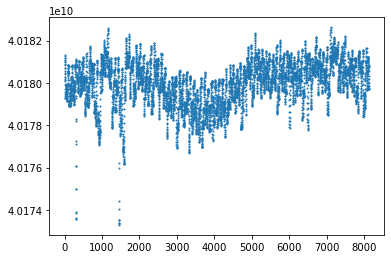

In [181]:
plt.scatter(range(len(errors)), errors, s = 1)